In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import scipy.signal as ss

In [2]:
holidays_events = pd.read_csv("https://www.dropbox.com/s/bxyamlpevkiwwoq/holidays_events.csv?dl=1")
oil = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1",parse_dates=['date'],index_col='date')
sample_submission = pd.read_csv("https://www.dropbox.com/s/68jjl61x6u3klos/sample_submission.csv?dl=1")
stores = pd.read_csv("https://www.dropbox.com/s/lcxn6r9bs2exguq/stores.csv?dl=1")
test = pd.read_csv("https://www.dropbox.com/s/cvdo1gn7r5lu2uz/test.csv?dl=1",index_col='id')
train = pd.read_csv("https://www.dropbox.com/s/s8p2b5awnuqfk0d/train.csv?dl=1",index_col='id')
transactions = pd.read_csv("https://www.dropbox.com/s/92fij9bcwt0e0cj/transactions.csv?dl=1")

C:\Users\ndzad\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
train['date'] = pd.to_datetime(train['date'])

Dzielimy próbkę na treningową i testową.

In [28]:
train2 = train.loc[(train['date']<'2016-06-01')]

In [27]:
test2 = train.loc[(train['date']>='2016-06-01')]

In [39]:
oil_train2 = oil.loc[(oil.index<'2016-06-01')].fillna(method ="bfill")
oil_test2 = oil.loc[(oil.index>='2016-06-01')].fillna(method ="bfill")

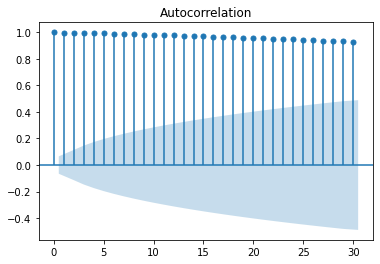

In [41]:
sm.graphics.tsa.plot_acf(oil_train2,lags=np.round(np.sqrt(len(oil_train2))))
plt.show()

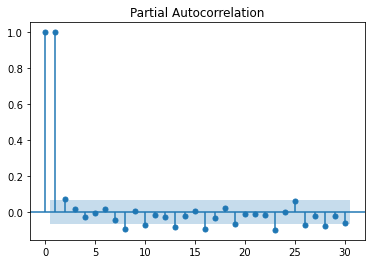

In [42]:
sm.graphics.tsa.plot_pacf(oil_train2,lags=np.round(np.sqrt(len(oil_train2))))
plt.show()

In [43]:
oil_diff = oil_train2.shift().diff().dropna()

In [51]:
sm.stats.acorr_ljungbox(oil_diff, lags=[np.round(np.sqrt(len(oil_diff)))], return_df=True)

,lb_stat,lb_pvalue
30,33.33492,0.308193


Zatem jest to biały szum.

In [64]:
mod_oil = sm.tsa.arima.ARIMA(oil_train2,order=(0,1,0)).fit()

C:\Users\ndzad\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\ndzad\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Users\ndzad\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


In [79]:
train2_avg= train2.groupby('date')['sales'].mean().to_frame()

In [81]:
#Funkcja pomocniczna do rysowania wykresów
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100, axiscolor ='black'):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.gca().title.set_color(axiscolor)
    plt.gca().xaxis.label.set_color(axiscolor)
    plt.gca().yaxis.label.set_color(axiscolor)
    plt.tick_params(colors=axiscolor, which='both')
    plt.show()

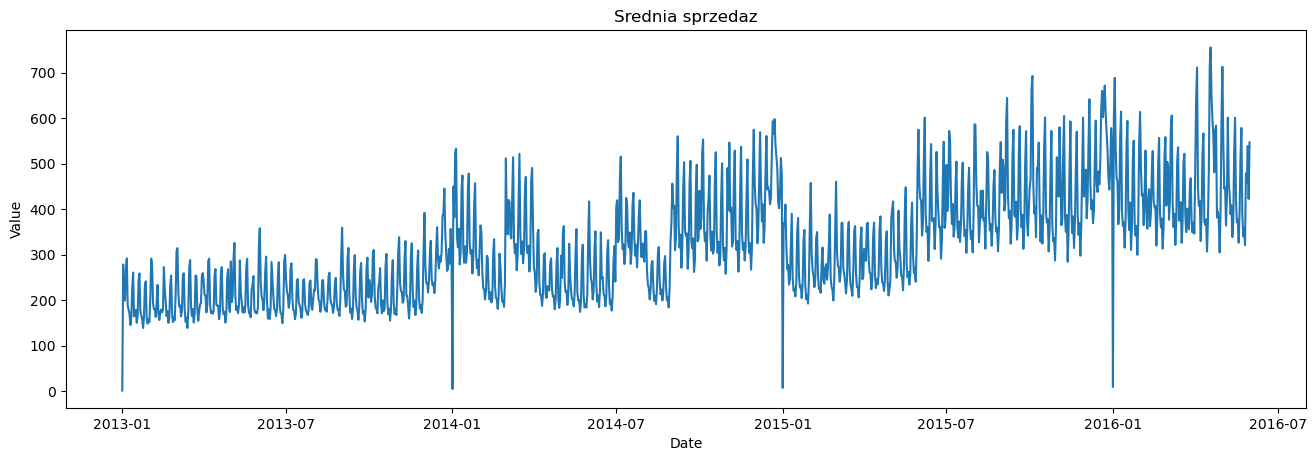

In [82]:
plot_df(train2_avg,x=train2_avg.index, y=train2_avg.sales, title='Srednia sprzedaz', axiscolor='black')

Wykres autokorelacji (ACF)

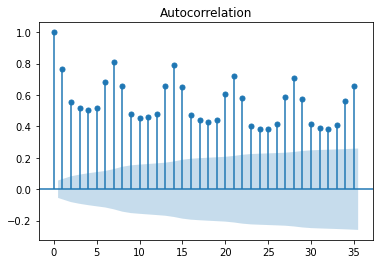

In [83]:
sm.graphics.tsa.plot_acf(train2_avg,lags=np.round(np.sqrt(len(train2_avg))))
plt.show()

Wykres cześciowych korelacji (PACF)

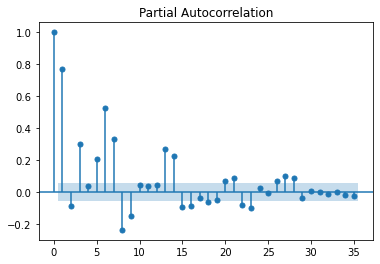

In [84]:
sm.graphics.tsa.plot_pacf(train2_avg,lags=np.round(np.sqrt(len(train2_avg))))
plt.show()

Różnicujemy szereg

In [85]:
train2_avg_diff = train2_avg.shift().diff().dropna()

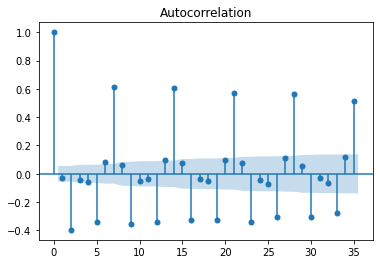

In [86]:
sm.graphics.tsa.plot_acf(train2_avg_diff,lags=np.round(np.sqrt(len(train2_avg_diff))))
plt.show()

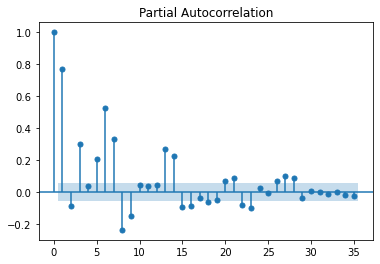

In [88]:
sm.graphics.tsa.plot_pacf(train2_avg,lags=np.round(np.sqrt(len(train2_avg))))
plt.show()

In [90]:
f, Pxx=ss.periodogram(train2_avg_diff)

In [93]:
Pxx

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])